In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, accuracy_score
    , confusion_matrix, ConfusionMatrixDisplay
)

import warnings
warnings.simplefilter('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")

In [3]:
# Custom tokenizer using SpaCy
def spacy_tokenizer(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]

In [4]:
# Load the dataset from Hugging Face:
df = pd.read_parquet("hf://datasets/tdavidson/hate_speech_offensive/data/train-00000-of-00001.parquet")

df.shape
df.head()
df.info()

(24783, 6)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   count                     24783 non-null  int64 
 1   hate_speech_count         24783 non-null  int64 
 2   offensive_language_count  24783 non-null  int64 
 3   neither_count             24783 non-null  int64 
 4   class                     24783 non-null  int64 
 5   tweet                     24783 non-null  object
dtypes: int64(5), object(1)
memory usage: 1.1+ MB


In [5]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [6]:
# Encode labels (spam: 1, ham: 0)

# 0: 'hate-speech', 1: 'offensive-language' or 2: 'neither'

df['label_actual'] = df['class'].map({0: 'hate-speech', 1: 'offensive-language', 2: 'neither' })

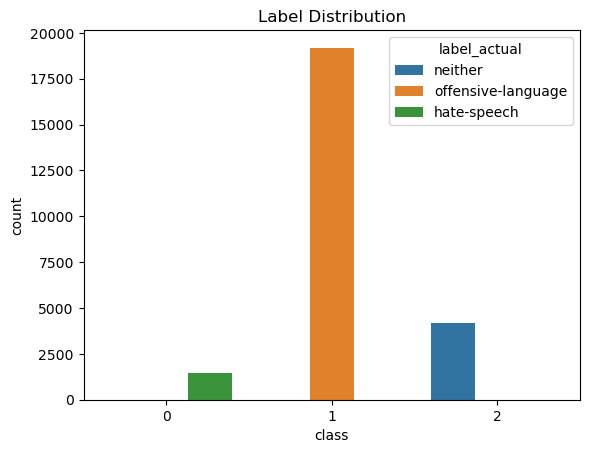

In [7]:
# Visualize label distribution
sns.countplot(
    x='class', data=df, hue='label_actual'
)
plt.title("Label Distribution")
plt.show();

In [8]:
df.head(1)

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet,label_actual
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,neither


In [9]:
X = df['tweet']
y = df['class']

X.shape, y.shape

((24783,), (24783,))

In [10]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=27, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19826,), (4957,), (19826,), (4957,))

In [10]:
# Vectorize text data using TfidfVectorizer (* with spaCy_tokenizer;)
tfidf = TfidfVectorizer(
    tokenizer=spacy_tokenizer, lowercase=True
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [11]:
X_train_tfidf.shape, X_test_tfidf.shape

X_train_tfidf

((4457, 7193), (1115, 7193))

<4457x7193 sparse matrix of type '<class 'numpy.float64'>'
	with 35701 stored elements in Compressed Sparse Row format>

In [12]:
# Initialize models for comparison
models = {
    'MultinomialNB': MultinomialNB(),
    'LogisticRegression': LogisticRegression(
        max_iter=1000, random_state=27
    ),
    'SVC': SVC(random_state=27),
    'LinearSVC': LinearSVC(
        max_iter=1000, random_state=27
    )
}

In [13]:
# Evaluate models
for name, model in models.items():
    
    model.fit(X_train_tfidf, y_train)
    
    y_pred = model.predict(X_test_tfidf)
    
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"{name} Accuracy: {accuracy:.4f}")

,alpha,1.0
,force_alpha,True
,fit_prior,True
,class_prior,None


MultinomialNB Accuracy: 0.9605


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,27
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


LogisticRegression Accuracy: 0.9605


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


SVC Accuracy: 0.9776


,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,27


LinearSVC Accuracy: 0.9848


In [15]:
# Select a base model (e.g., MultinomialNB) for hyperparameter tuning
base_model = LinearSVC(
    max_iter=1000, random_state=27
)

In [16]:
# Set up hyperparameter grid for GridSearchCV
param_grid = {
    'C': np.logspace(-2,2,17)
    , 'penalty': ['l2']  # 'l1' only works with 'liblinear' solver and 'dual=False'
    , 'loss': ['hinge', 'squared_hinge']
    , 'dual': ["auto"]  # For penalty='l2' and loss='squared_hinge', dual can be True or False
    , 'tol': [1e-4, 1e-3, 1e-2]
}

# Perform GridSearchCV
grid_search = GridSearchCV(
    base_model
    , param_grid
    , cv=5
    , scoring='accuracy'
)

grid_search.fit(X_train_tfidf, y_train)

,estimator,LinearSVC(random_state=27)
,param_grid,"{'C': array([1.0000...00000000e+02]), 'dual': ['auto'], 'loss': ['hinge', 'squared_hinge'], 'penalty': ['l2'], ...}"
,scoring,'accuracy'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [17]:
# Print best hyperparameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'C': 1.7782794100389228, 'dual': 'auto', 'loss': 'hinge', 'penalty': 'l2', 'tol': 0.0001}
Best Cross-Validation Accuracy: 0.9800304993130105


In [18]:
# Evaluate best model on test data
best_model = grid_search.best_estimator_

# Now FIT the best_model (MUST DO BEFORE PREDICTING!!! {otherwise, you essentially reset the model! :o })
best_model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,loss,'hinge'
,dual,'auto'
,tol,0.0001
,C,1.7782794100389228
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,27


In [19]:
y_test_pred = best_model.predict(X_test_tfidf)

print("Test Accuracy:", accuracy_score(y_test, y_test_pred))
confusion_matrix(y_test, y_test_pred)
print(classification_report(y_test, y_test_pred))

Test Accuracy: 0.9856502242152466


array([[954,   3],
       [ 13, 145]])

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       957
           1       0.98      0.92      0.95       158

    accuracy                           0.99      1115
   macro avg       0.98      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



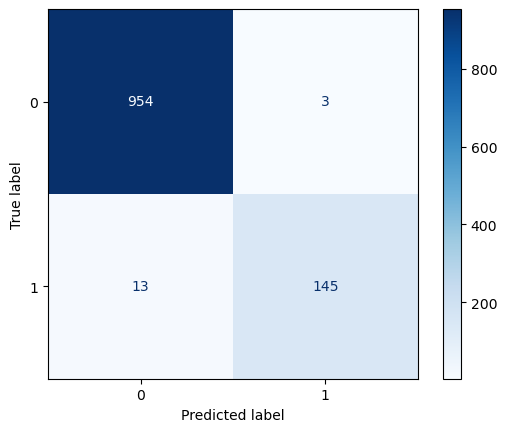

In [20]:
ConfusionMatrixDisplay.from_estimator(
    best_model, X_test_tfidf, y_test
    , cmap='Blues'
);

In [21]:
# Build a pipeline for testing on sample strings
pipeline = Pipeline([
    ("tfidf", TfidfVectorizer(tokenizer=spacy_tokenizer, lowercase=True))
    , ('model', best_model)
])

In [22]:
# HAVE TO FIT THE PIPES!!!
# Since the model is already trained, can fit directly to X, y;

pipeline.fit(X, y)

,steps,"[('tfidf', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,input,'content'
,encoding,'utf-8'
,decode_error,'strict'
,strip_accents,None
,lowercase,True
,preprocessor,None
,tokenizer,<function spa...t 0x173894720>


In [23]:
# Test pipeline on sample strings
sample_strings = [
    "Congratulations! You've won a free ticket to Bahamas.",
    "Hey, are we still on for lunch tomorrow?",
    "Urgent! Your account has been compromised. Click this link.",
    "Congratulations son! Your Mother is so proud!",
    "Enlarge your portfolio 1000% with my proven investment secrets!",
    "We should link up tomorrow!",
    "This airline sucks!"
]

predictions = pipeline.predict(sample_strings)

# Display predictions
for text, label in zip(sample_strings, predictions):
    print(f"Message: {text} -> Prediction: {'Spam' if label == 1 else 'Ham'}\n")

Message: Congratulations! You've won a free ticket to Bahamas. -> Prediction: Spam

Message: Hey, are we still on for lunch tomorrow? -> Prediction: Ham

Message: Urgent! Your account has been compromised. Click this link. -> Prediction: Spam

Message: Congratulations son! Your Mother is so proud! -> Prediction: Ham

Message: Enlarge your portfolio 1000% with my proven investment secrets! -> Prediction: Spam

Message: We should link up tomorrow! -> Prediction: Ham

Message: This airline sucks! -> Prediction: Ham



In [28]:
X_test_tfidf.shape

(1115, 7193)

In [33]:
base_model

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,27


In [31]:
best_model

,penalty,'l2'
,loss,'hinge'
,dual,'auto'
,tol,0.0001
,C,1.7782794100389228
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,27
